### Doublet Detection from Count Matrix Dataset 2

In [1]:
%config InlineBackend.figure_formats = ['png2x']  # increase resolution on retina screens
import scanpy.api as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pl
from collections import OrderedDict
from sklearn import metrics

sc.settings.verbosity = 1
sc.settings.set_dpi(120)
sc.logging.print_version_and_date()

Running Scanpy version 0.2.5+4.gc2a4f5c on 2017-08-02 13:00.


/home/jovyan/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
adata = sc.read('../shared_scratch/group6/dataset2_train.expr.mtx', cache=True).transpose()
adata.var_names = np.genfromtxt('../shared_scratch/group6/dataset2_train.geneNames.txt', dtype=str)
adata.smp_names = np.genfromtxt('../shared_scratch/group6/dataset2_train.cellNames.txt', dtype=str)
adata_raw = adata.copy()

In [3]:
labels = np.genfromtxt('../jamboree/doublet-datasets/dataset2/Ye032917_S4_L003_001_train_labels.txt', dtype=str)
barcodes_labels = set(labels[:, 0])

In [4]:
N_TOP_GENES = 3000

### Get the count matrix for which we have labels 

In [5]:
filter_samples = np.array([barcode in barcodes_labels for barcode in adata.smp_names])

In [6]:
adata = adata[filter_samples, :]

In [7]:
labels_dict = dict(labels)
ordered_labels = [labels_dict[barcode] for barcode in adata.smp_names]
adata.smp['labels'] = ordered_labels
adata.add['labels_names'] = ['singlet', 'doublet']

In [8]:
sc.pp.filter_genes(adata, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell
adata.smp['log_n_counts_all'] = np.log1p(adata.smp['n_counts'])
filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=N_TOP_GENES, log=False)
adata = adata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(adata)           # need to redo normalization after filtering
sc.pp.log1p(adata)  # log transform: X = log(X + 1)
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=50)

In [9]:
sc.tl.tsne(adata)

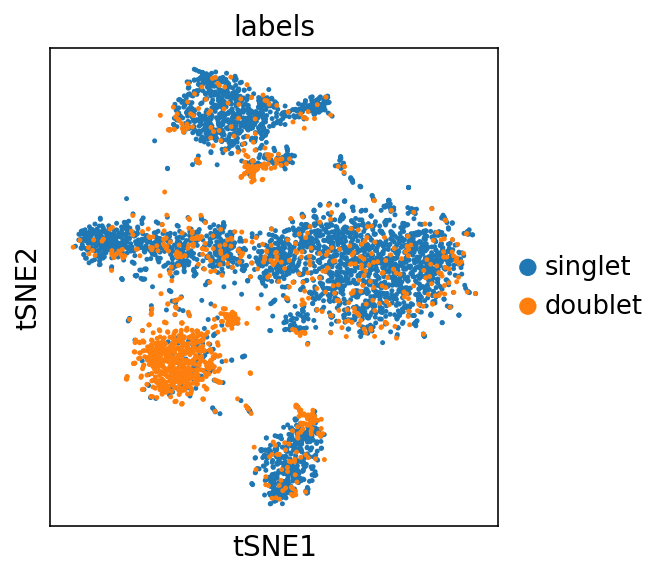

In [10]:
ax = sc.pl.tsne(adata, color='labels')

In [11]:
sc.write('dataset2_train', adata)

In [12]:
sc.tl.louvain(adata, resolution=0.6)

In [13]:
sc.write('dataset2_train', adata)

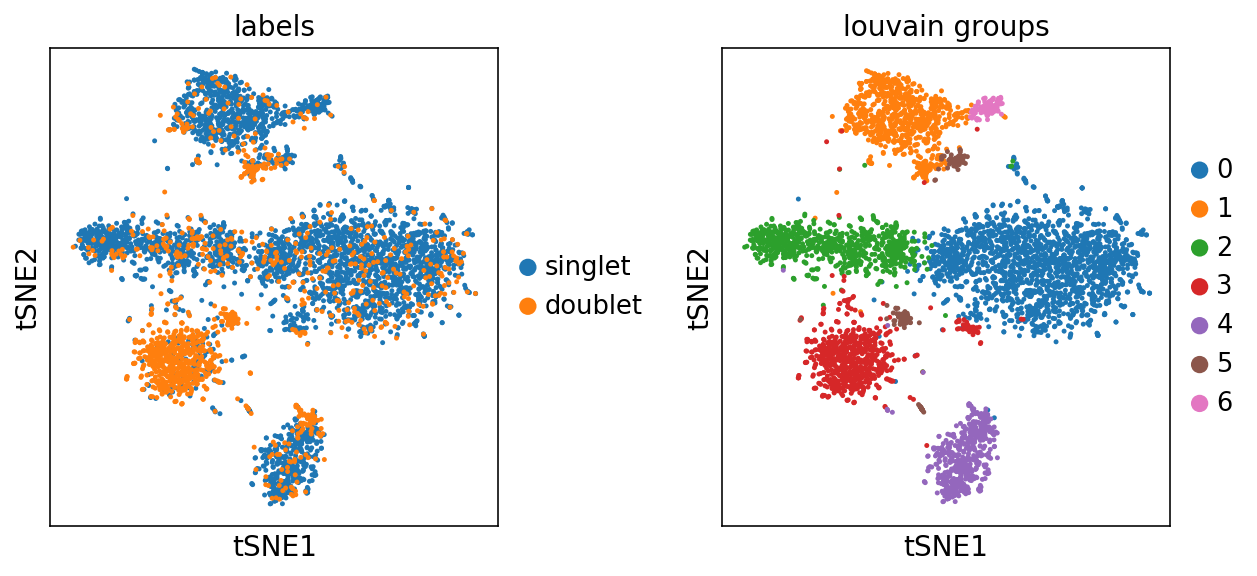

In [14]:
axs = sc.pl.tsne(adata, color=['labels', 'louvain_groups'])

### Getting the non-normalized filtered data matrix

In [15]:
adata = sc.read('dataset2_train')

In [16]:
adata_not_norm = adata.copy()

In [17]:
adata_raw_sample_filtered = adata_raw[filter_samples, :]
adata_raw_filtered = adata_raw_sample_filtered[:, filter_result.gene_subset]
adata_not_norm.X = adata_raw_filtered.X

In [18]:
sc.write('dataset2_train_not_norm', adata_not_norm)

### Reclustering

Recluster the matrix and compare normalized with non-normalized data.

In [19]:
adata_not_norm = sc.read('dataset2_train_not_norm')
adata = sc.read('dataset2_train')

cluster 0 with size 1872
    normalized data


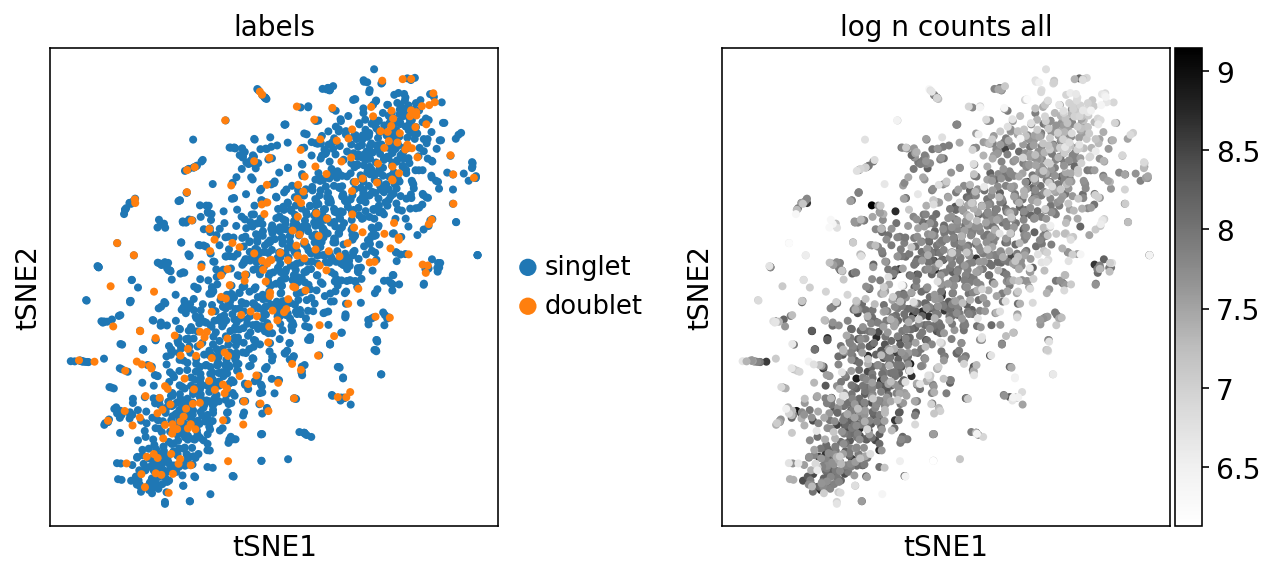

    non-normalized data


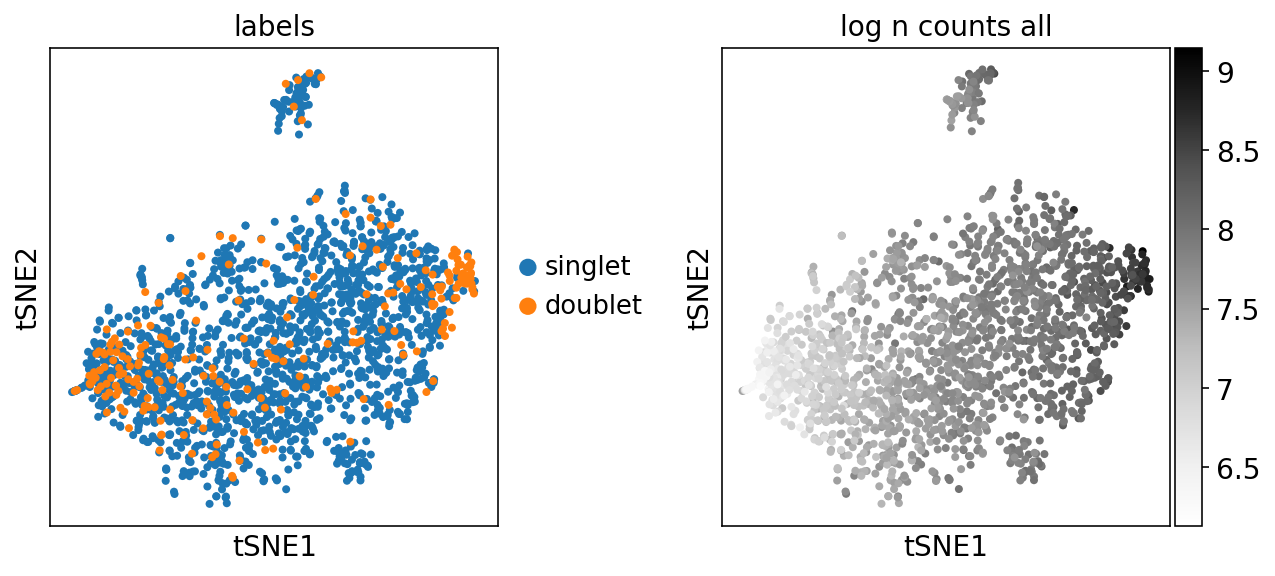

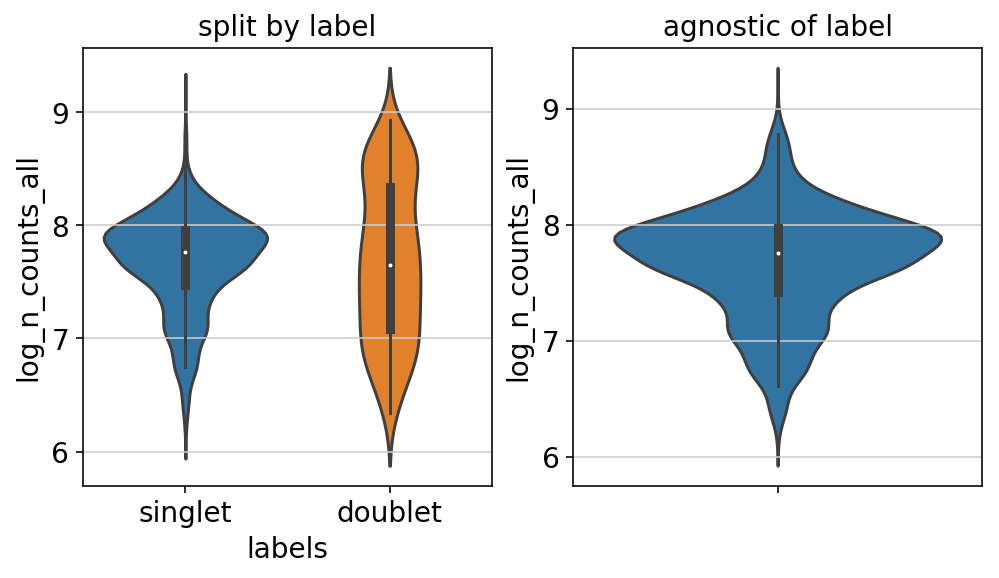

cluster 1 with size 794
    normalized data


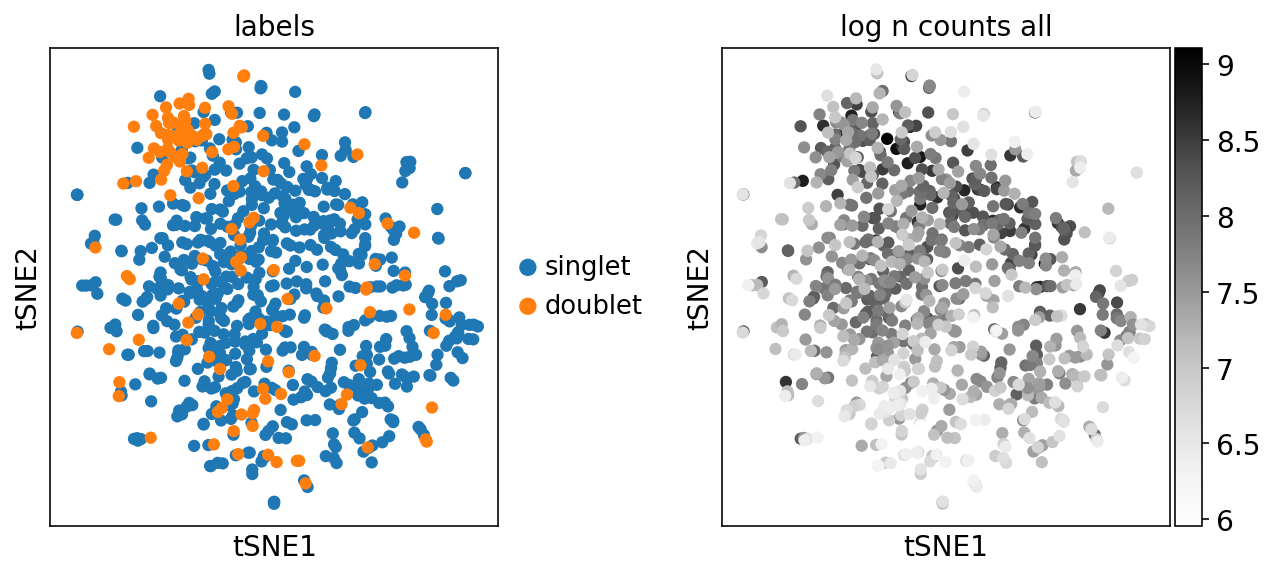

    non-normalized data


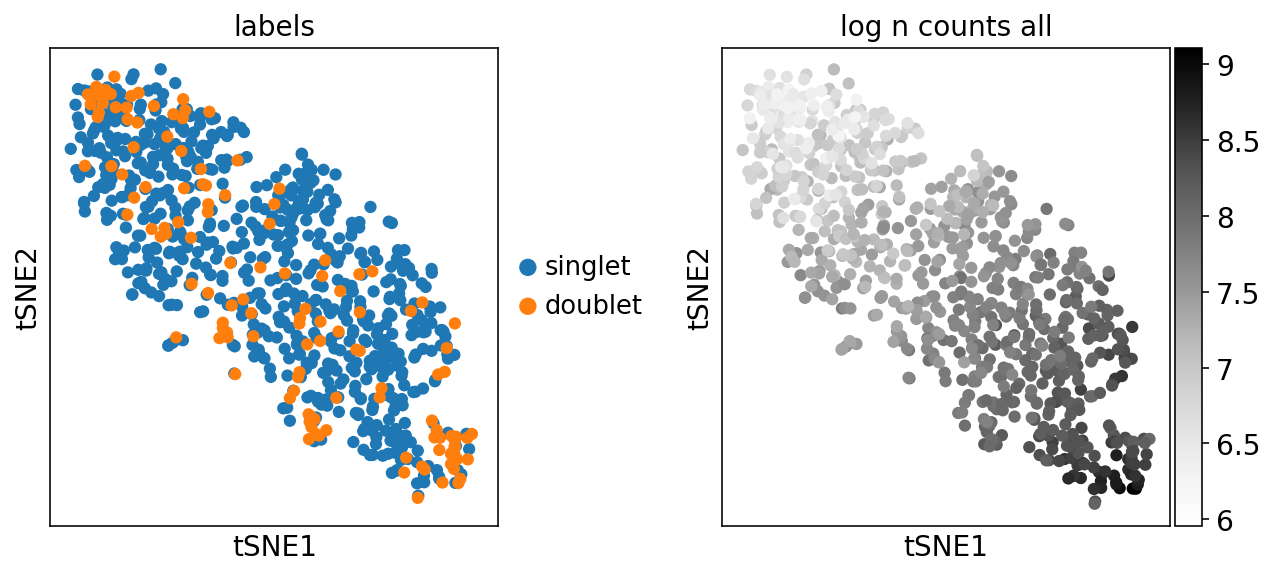

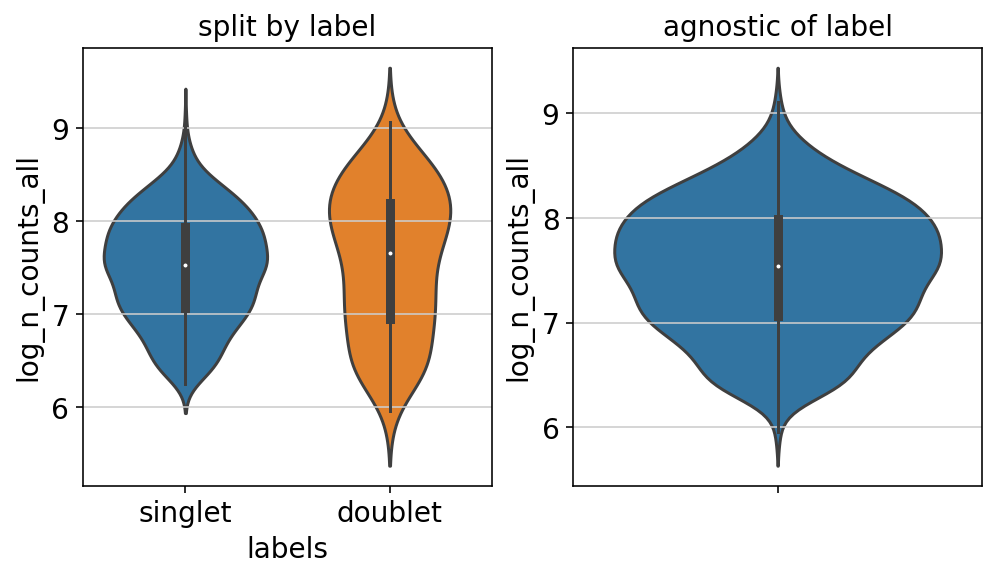

cluster 2 with size 773
    normalized data


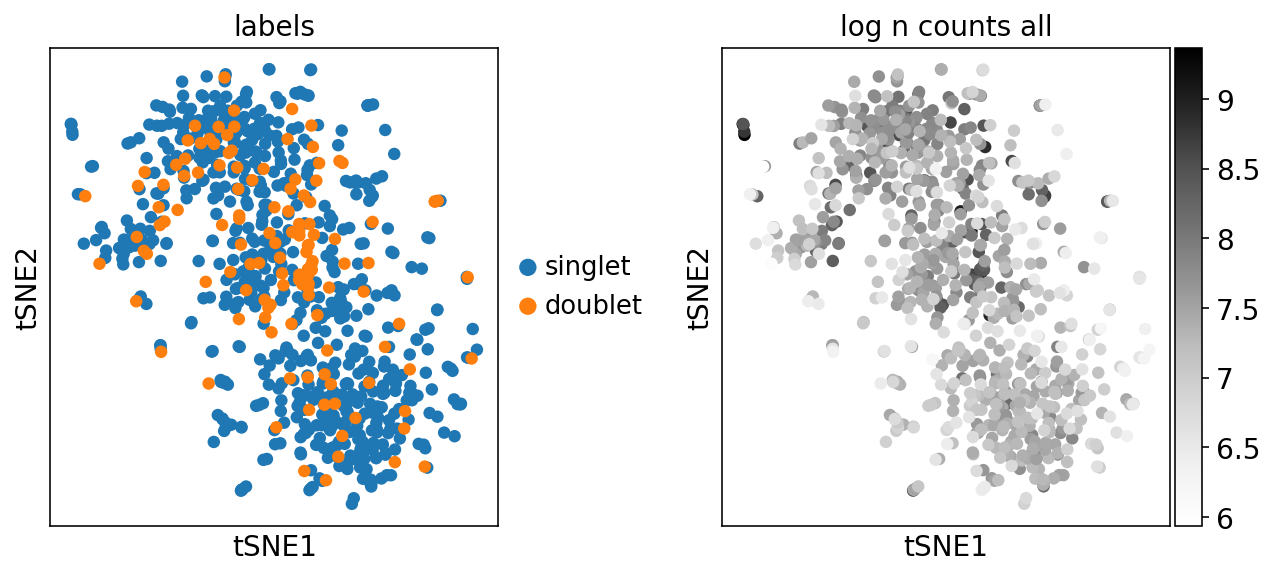

    non-normalized data


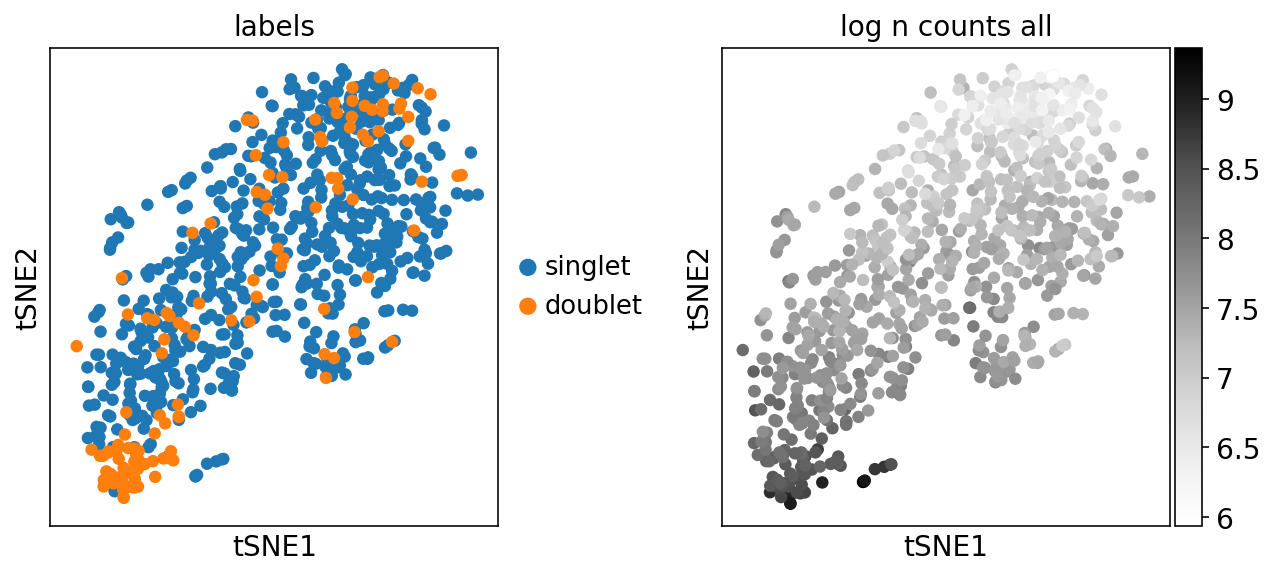

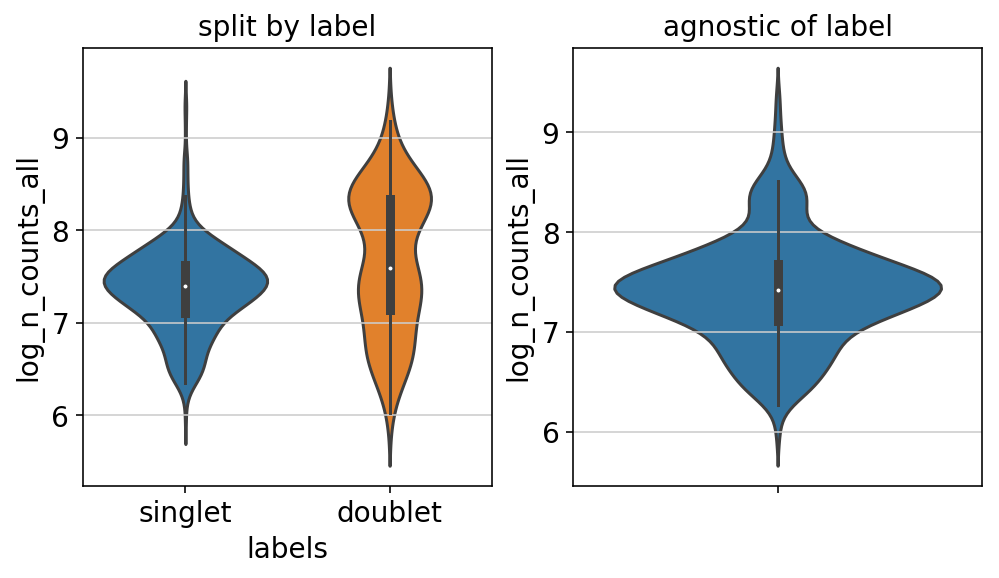

cluster 3 with size 685
    normalized data


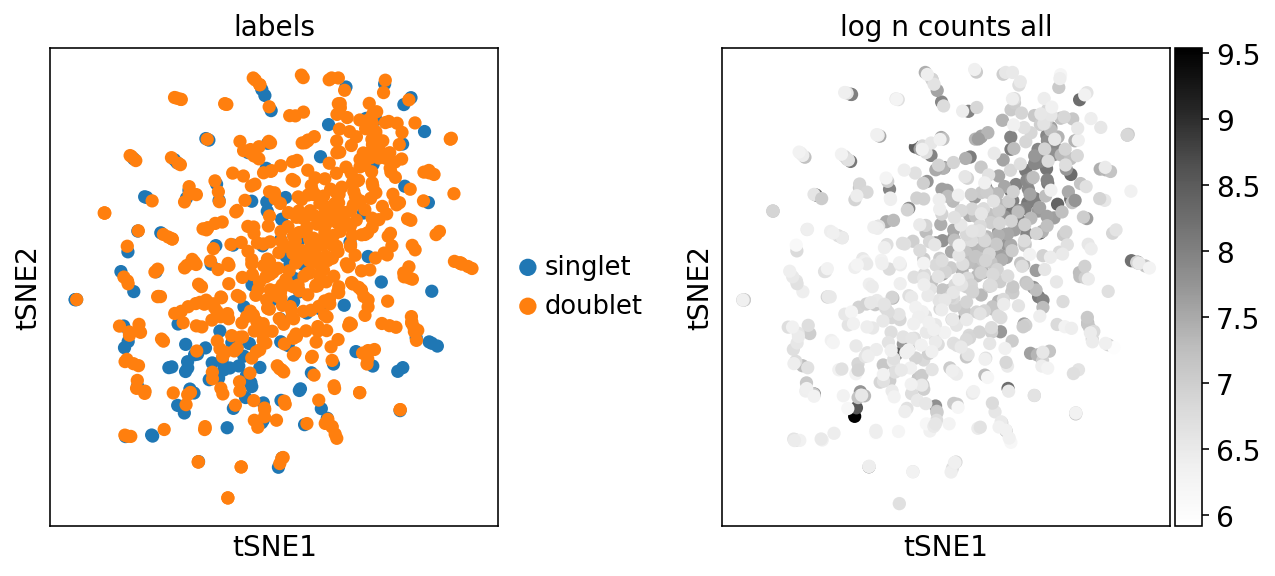

    non-normalized data


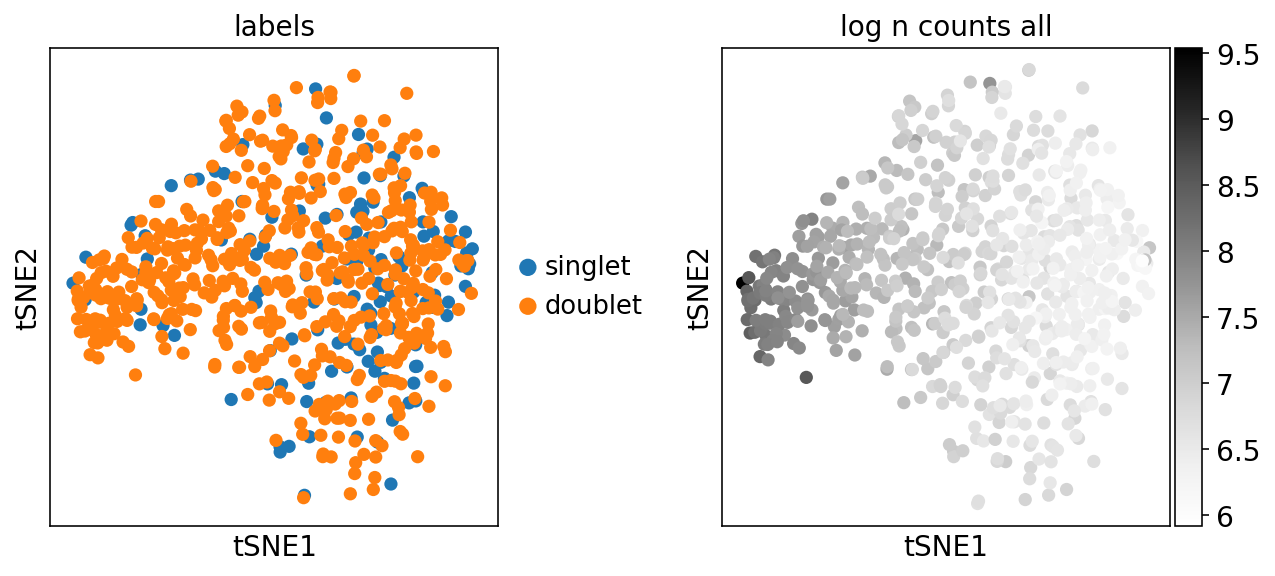

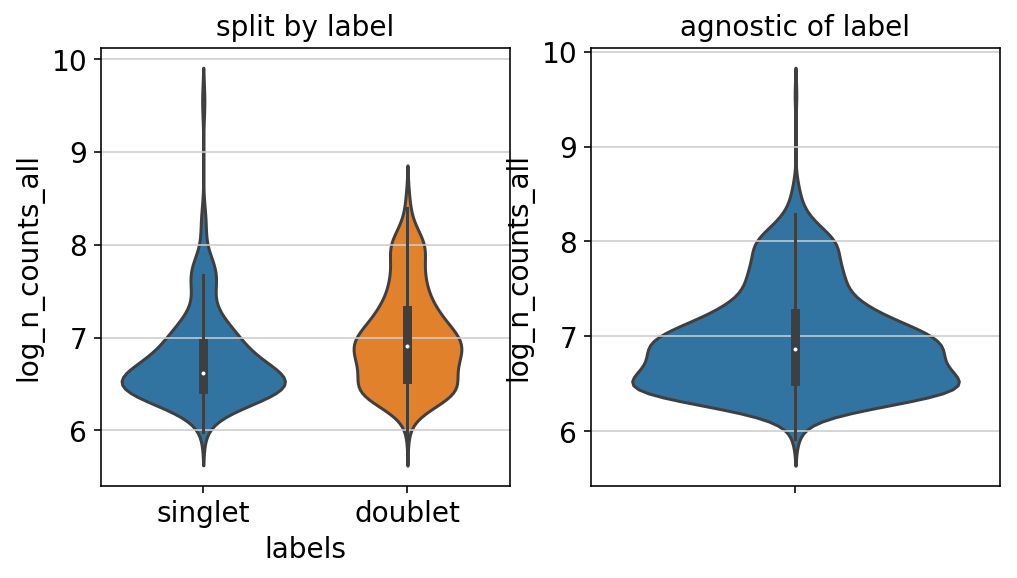

cluster 4 with size 509
    normalized data


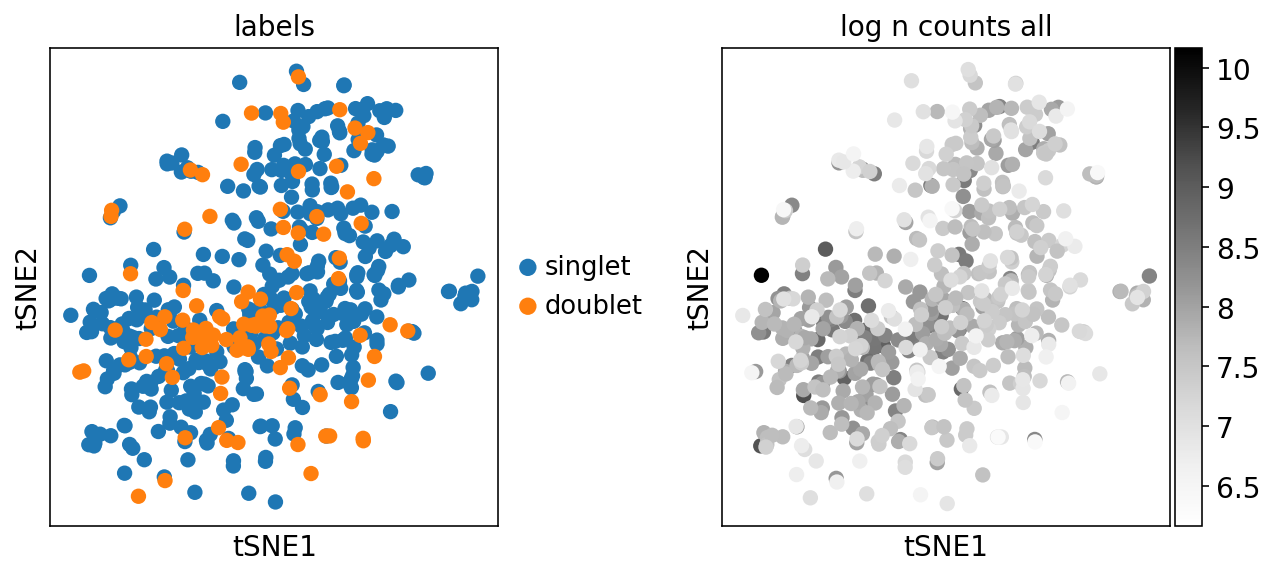

    non-normalized data


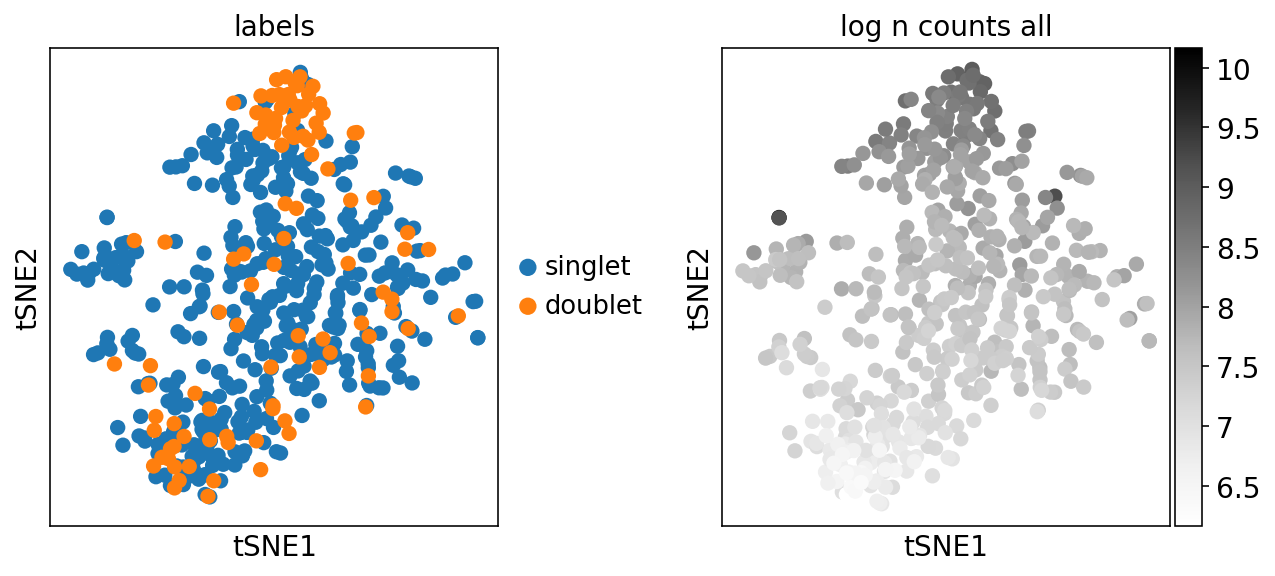

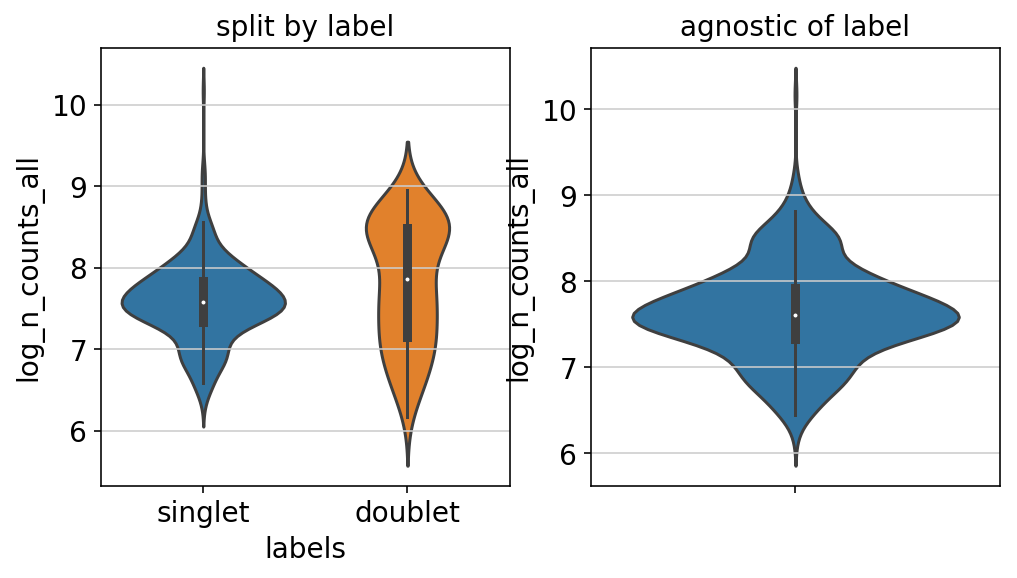

In [20]:
sc.settings.verbosity = 0
for group in adata.add['louvain_groups_names']:
    cluster_size = np.sum(adata.smp['louvain_groups'] == group)
    if cluster_size < 0.1*adata.n_smps: continue
    print('cluster', group, 'with size', cluster_size)
    print('    normalized data')
    adata_group = adata[adata.smp['louvain_groups'] == group]
    sc.tl.tsne(adata_group, recompute_pca=True)
    sc.pl.tsne(adata_group, color=['labels', 'log_n_counts_all'])
    print('    non-normalized data')
    adata_not_norm_group = adata_not_norm[adata.smp['louvain_groups'] == group]
    sc.tl.tsne(adata_not_norm_group, recompute_pca=True)
    # sc.tl.louvain(adata_not_norm_group, resolution=0.6, recompute_graph=True)
    sc.pl.tsne(adata_not_norm_group, color=['labels', 'log_n_counts_all'])
    fig, axs = pl.subplots(ncols=2, figsize=(8, 4))
    sns.violinplot(data=adata_group.smp.to_df(), x='labels', y='log_n_counts_all',
                   ax=axs[0], order=adata.add['labels_names'])
    axs[0].set_title('split by label')
    sns.violinplot(data=adata_group.smp.to_df(), y='log_n_counts_all', ax=axs[1])
    axs[1].set_title('agnostic of label')
    pl.show()

### Classifying

In [2]:
adata_not_norm = sc.read('dataset2_train_not_norm')
adata = sc.read('dataset2_train')

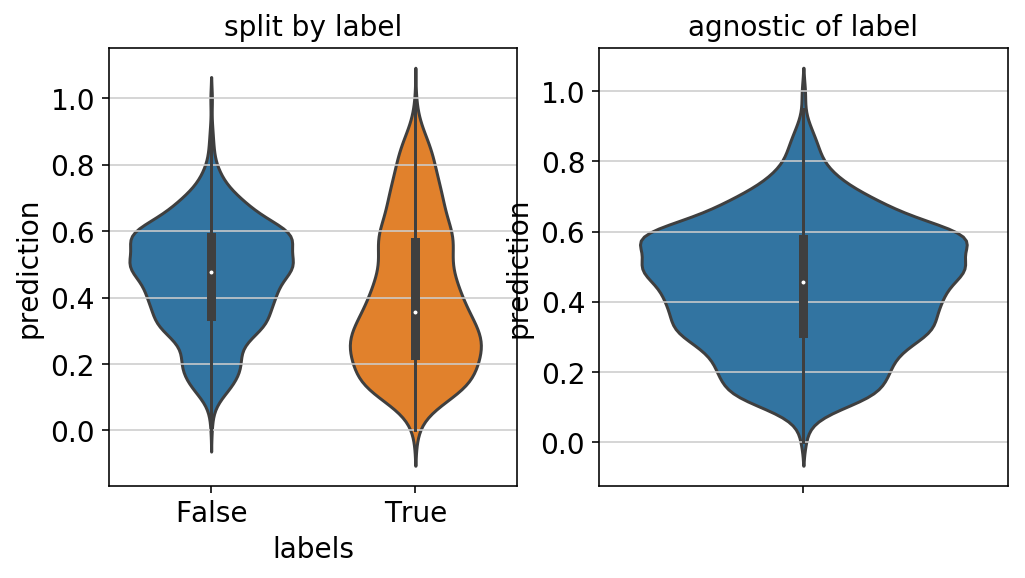

fraction singlets 0.75285991798
precision singlets 0.653138528139
recall singlets 0.346043577982
AUC 0.395403329194


In [3]:
sc.settings.verbosity = 0
reference = []
prediction = []
for group in adata.add['louvain_groups_names']:
    cluster_size = np.sum(adata.smp['louvain_groups'] == group)
    if cluster_size < 0.1*adata.n_smps: continue
    adata_group = adata[adata.smp['louvain_groups'] == group]
    group_reference = adata_group.smp['labels'] == 'doublet'
    reference += list(group_reference)
    scaled_counts = (adata_group.smp['log_n_counts_all']
                     - np.median(adata_group.smp['log_n_counts_all']))
    scaled_counts -= np.min(scaled_counts)
    scaled_counts /= np.max(scaled_counts)
    prediction += list(scaled_counts)
fpr, tpr, thresholds = metrics.roc_curve(reference, prediction)
df = pd.DataFrame({'labels': reference, 'prediction': prediction})
fig, axs = pl.subplots(ncols=2, figsize=(8, 4))
sns.violinplot(data=df, x='labels', y='prediction',
               ax=axs[0])
axs[0].set_title('split by label')
sns.violinplot(data=df, y='prediction', ax=axs[1])
axs[1].set_title('agnostic of label')
pl.show()
reference = np.array(reference)
prediction = np.array(prediction)
print('fraction singlets', np.sum(~reference)/len(reference))
print('precision singlets', metrics.precision_score(~reference, prediction < 0.4))
print('recall singlets', metrics.recall_score(~reference, prediction < 0.4))
fpr, tpr, thresholds = metrics.roc_curve(reference, prediction)
print('AUC', metrics.auc(fpr, tpr))

### Compute centroids

Explain data by centroids; should be doomed to fail.

In [23]:
adata_not_norm = sc.read('dataset2_train_not_norm')
adata_not_norm.X = adata_not_norm.X.toarray()
adata = sc.read('dataset2_train')

In [24]:
def add_centroid(centroids, name, Y, mask):
    masked_values = Y[mask]
    if masked_values.shape[0] == 0: return
    median = np.median(masked_values, axis=0)
    i = np.argmin(np.sum(np.abs(masked_values - median), axis=1))
    centroids[name] = masked_values[i]

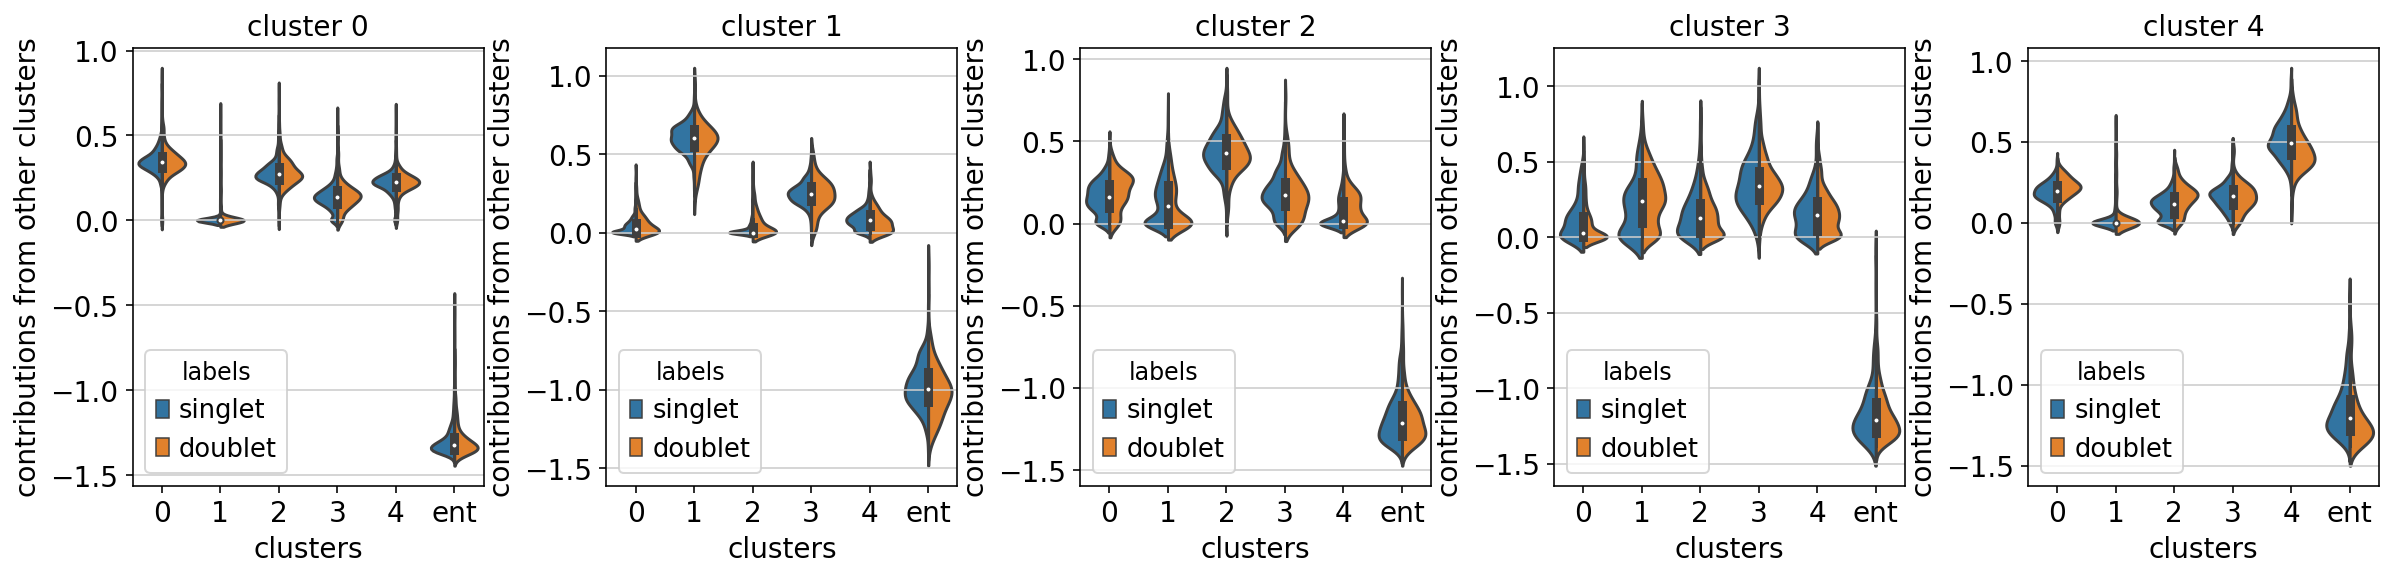

In [25]:
sc.settings.verbosity = 0
centroids = OrderedDict()
for group in adata.add['louvain_groups_names']:
    group_mask = adata.smp['louvain_groups'] == group
    cluster_size = np.sum(group_mask)
    if cluster_size < 0.1*adata.n_smps: continue
    add_centroid(centroids, group, adata.X, group_mask)
fig, axs = pl.subplots(ncols=len(centroids), figsize=(4*len(centroids), 4), gridspec_kw={'wspace': 0.35})
for igroup, group in enumerate(centroids):
    group_mask = adata.smp['louvain_groups'] == group
    cluster_size = np.sum(group_mask)
    df = pd.DataFrame({g: np.dot(adata.X[group_mask], centroids[g]) for g in centroids})
    df = df.sub(df.min(axis=1), axis=0)  # subtract row-wise minimum
    df = df.div(df.sum(axis=1), axis=0)  # divide by row-sum to make it probability
    df['ent'] = np.sum(df.values * np.log(df.values+1e-6), axis=1)
    df['labels'] = adata[group_mask].smp['labels']
    df = pd.melt(df, id_vars='labels', value_vars=[k for k in centroids.keys()] + ['ent'],
                 var_name='clusters', value_name='contributions from other clusters')
    sns.violinplot(data=df, x='clusters', y='contributions from other clusters', hue='labels', split=True,
                   hue_order=['singlet', 'doublet'], scale='width', ax=axs[igroup])
    axs[igroup].set_title('cluster {}'.format(group))
pl.show()